## TVL Forecasting with PyOSO
*A quick-start notebook guide*

## Overview

In this tutorial you’ll forecast the Total Value Locked (TVL) of any DeFi protocol using PyOSO. You’ll:

1. **Connect** to PyOSO and pull historical TVL data.  
2. **Explore** the raw series to understand recent behaviour.  
3. **Pick a date window** to train and evaluate your models.  
4. **Choose a modelling approach**  
   - **SARIMA** – captures the protocol’s own historical patterns.  
   - **Linear Regression** – links protocol TVL to broader market trends.  
5. **Train & forecast** with both approaches.  
6. **Visualise & compare** forecasts to actual outcomes.  

### 1. Connect to PyOSO & grab data

Load your API key, instantiate a Client, and pull daily TVL:

In [1]:
from dotenv import load_dotenv
import os
import pandas as pd
from pyoso import Client

load_dotenv()

OSO_API_KEY = os.environ['OSO_API_KEY']
client = Client(api_key=OSO_API_KEY)

### Query tips

| Scenario | What to query | Extra filters |
|----------|---------------|---------------|
| You know the *project* ID | `int_events_daily_to_project__defillama_tvl` | `project_id` |
| You know the *DefiLlama* protocol | `int_events_daily__defillama_tvl` | `to_artifact_name` |
| Restrict to one chain | either query | `from_artifact_namespace` |

For this tutorial, I'll be forecasting the TVL of Renzo Protocol on Optimism for 90 days based on it's TVL trends from '2024-09-01' to '2024-12-31'

In [2]:
protocol = "renzo"
chain = 'optimism'
start_date = '2024-09-01'
end_date = '2024-12-31'

tvl_df = client.to_pandas(f"""
    SELECT
        bucket_day as date,
        from_artifact_name as unit,
        amount as TVL
        FROM int_events_daily__defillama_tvl 
        WHERE to_artifact_name = '{protocol}'
            AND from_artifact_namespace = '{chain}'
            AND bucket_day BETWEEN DATE '{start_date}' AND DATE '{end_date}'
        ORDER BY 1
""")

### 2. Explore the data  

Before we get into modelling, I recommend first exploring the data and getting familiar with it's trends. We want to see if we notice anything immediately about the data that might help inform future decisions surrounding model selection, parameter selection, etc. 

So, I'll start by plotting a line chart of our TVL data and see what we can notice

> **Why explore first?**  
> Statistical models assume things like stationarity and homoscedastic errors. A 10-second chart frequently tells you if those assumptions are ridiculous and whether you need to difference, transform, or pick a different algorithm entirely.

In [3]:
import matplotlib.pyplot as plt

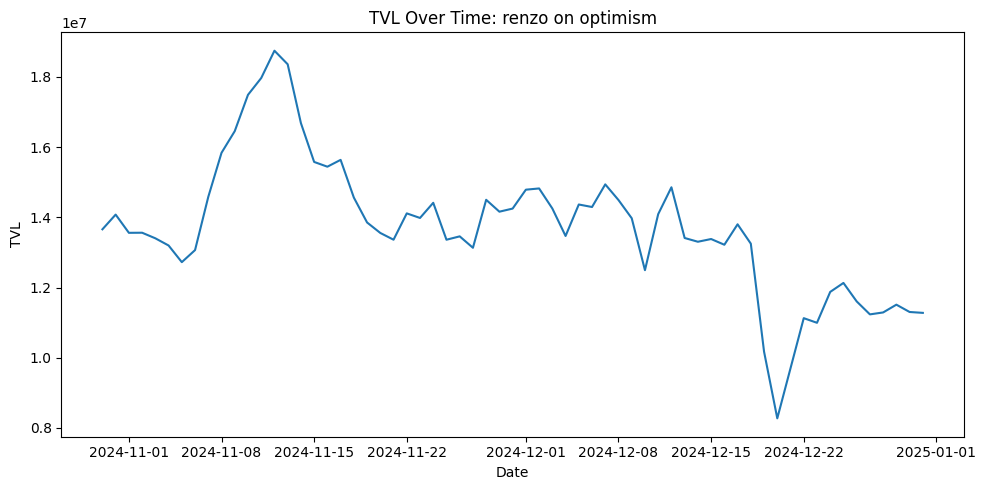

In [17]:
# ensure 'date' is a datetime type
tvl_df['date'] = pd.to_datetime(tvl_df['date'])

# sort by date
tvl_df = tvl_df.sort_values('date')

# plot
plt.figure(figsize=(10, 5))
plt.plot(tvl_df['date'], tvl_df['TVL'])
plt.title(f"TVL Over Time: {protocol} on {chain}")
plt.xlabel("Date")
plt.ylabel("TVL")
plt.tight_layout()
plt.show()

### 3. Model selection logic  

Looking at our line chart, we can see that renzo TVL appears to be declining over our training period. Combining this with a little bit of real world context, we can conclude that we will likely need a model that will be able to incorporate the recent negative trends across the market as a whole.

The two models I'll walk through are: 

- **SARIMA**  
*Great when*: the protocol’s own past behaviour is the sole driver (e.g. single-chain staking dApps).  
*Weakness*: oblivious to exogenous market moves.

- **Linear Regression on market proxy**  
*Great when*: TVL closely follows overall market sentiment.  
*Weakness*: needs an external “market” series and therefore can’t predict further out than that series.

For Renzo on Optimism, I have a hunch that the Linear Regression model will perform much better, but I’ll still walk through **both** models and compare.

In [5]:
import numpy as np
import pandas as pd
from pmdarima import auto_arima

def bootstrap_series(series: np.ndarray, rng: np.random.Generator, bootstrap_ratio: float = 0.33) -> np.ndarray:
    """
    Partially bootstraps the input series by randomly replacing a fraction of its values.
    
    series: the original data array
    rng: numpy random generator instance
    bootstrap_ratio: fraction of points to resample (default 0.33)
    
    Returns a new array where selected entries have been replaced by random draws
        from the original series
    """

    # total number of data points in the series
    n = len(series)

    # compute how many points to replace
    k = int(bootstrap_ratio * n)

    # choose k unique indices to replace
    idx = rng.choice(n, size=k, replace=False)

    # copy the series to avoid mutating the original
    boot = series.copy()

    # draw k replacement values from the series (with replacement)
    repl = rng.choice(series, size=k, replace=True)

    # overwrite the selected positions with the replacement values
    boot[idx] = repl

    return boot


def forecast_sarima(
    history_df: pd.DataFrame,
    target_col: str,
    forecast_days: int,
    bootstrap_ratio: float = 0.0,
    seasonality: int = 0,
    chunk_size: int = 3,
    noise_std: float = 0.05,
    random_state: int | None = None,
    handle_negative: bool = False
) -> pd.DataFrame:
    """
    Forecast the next `forecast_days` days of `target_col` using (S)ARIMA + optional bootstrapping.

    history_df: must have columns ['date', target_col], where 'date' is daily.
    Returns a DataFrame with future dates and 'forecasted_{target_col}'.
    """
    # setup
    rng = np.random.RandomState(random_state)
    date_col = "date"

    # aggregate & sort
    df = (
        history_df
        .groupby(date_col)[target_col].sum()
        .reset_index()
        .sort_values(by=date_col)
        .reset_index(drop=True)
    )

    y = df[target_col].values
    if y.size == 0:
        raise ValueError("No historical data provided.")

    # constant series shortcut
    if np.unique(y).size == 1:
        const = y[0]
        future_dates = pd.date_range(
            start=pd.to_datetime(df[date_col].iloc[-1]) + pd.Timedelta(days=1),
            periods=forecast_days,
            freq="D"
        )
        return pd.DataFrame({
            "date": future_dates,
            f"forecasted_{target_col}": [const] * forecast_days
        })

    # negative‐value handling
    offset = 0
    if handle_negative:
        mn = y.min()
        if mn < 0:
            offset = abs(mn) + 1
            y = y + offset

    # log‐transform
    y_log = np.log1p(y)
    y_log = np.nan_to_num(y_log, nan=0.0, posinf=0.0, neginf=0.0)

    predictions = []
    remaining = forecast_days

    # iterative chunked forecasting
    while remaining > 0:
        window = min(chunk_size, remaining)
        y_curr = (
            bootstrap_series(y_log, rng, bootstrap_ratio)
            if bootstrap_ratio > 0 else y_log
        )
        y_curr = np.nan_to_num(y_curr, nan=0.0, posinf=0.0, neginf=0.0)

        model = auto_arima(
            y_curr,
            seasonal=(seasonality > 0),
            m=seasonality,
            stepwise=True,
            suppress_warnings=True,
            error_action="ignore",
            trace=False,
            ensure_all_finite=True
        )

        # predict in log‐domain
        pred_log = model.predict(n_periods=window)
        pred = np.expm1(pred_log)

        # add noise
        noise = rng.normal(loc=1.0, scale=noise_std, size=window)
        pred_noisy = pred * noise

        # revert offset
        if handle_negative and offset:
            pred_noisy = pred_noisy - offset

        predictions.extend(pred_noisy)

        # append to training for next iter
        continued_log = np.log1p(
            np.clip(pred_noisy + offset if handle_negative else pred_noisy, 1e-9, None)
        )
        y_log = np.concatenate([y_log, continued_log])

        remaining -= window

    # build future dates
    last_date = pd.to_datetime(df[date_col].iloc[-1])
    future_dates = pd.date_range(
        start=last_date + pd.Timedelta(days=1),
        periods=forecast_days,
        freq="D"
    )

    return pd.DataFrame({
        "date": future_dates,
        f"forecasted_{target_col}": predictions
    })

### 4. Forecast with SARIMA  

Now, let's forecast based on the model. I designed the model to be recursive, so it'll forecast chunks at a time, and then incorporate these forecasted chunks back into it's next predictions. We will also use some slight bootstrappign and a noise distribution to adjust the data after it's forecasted, providing some of the real world variability you can expect from markets.

Key configurable knobs:

| Parameter | Intuition |
|-----------|-----------|
| `chunk_size` | Re-train frequency – smaller chunks adapt faster but add noise. |
| `bootstrap_ratio` | Randomly replaces a share of history to simulate alternative realities. |
| `noise_std` | Multiplicative noise injected into each forecast step. |
| `seasonality` | `m` in `(S)ARIMA`; 0 = no seasonality. |

For this tutorial, I'll plot **five** different scenarios to reflect how changes to parameters can impact results.

In [6]:
import warnings
from functools import reduce
import pandas as pd

# suppress the SARIMA FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)

# prepare a list to collect each forecast
dfs = []

# 1) default forecast (bootstrap_ratio=0.0, default noise_std=0.05)
df_default = forecast_sarima(
    history_df=tvl_df,
    target_col='TVL',
    forecast_days=90,
    chunk_size=2
).rename(columns={'forecasted_TVL': 'forecast_default'})
dfs.append(df_default)

# 2) noise_std = 0.01 (virtual no noise used)
df_001 = forecast_sarima(
    history_df=tvl_df,
    target_col='TVL',
    forecast_days=90,
    noise_std=0.01,
    chunk_size=2
).rename(columns={'forecasted_TVL': 'forecast_noise001 (no noise)'})
dfs.append(df_001)

# 3) noise_std = 0.15 (high noise used)
df_015 = forecast_sarima(
    history_df=tvl_df,
    target_col='TVL',
    forecast_days=90,
    noise_std=0.15,
    chunk_size=2
).rename(columns={'forecasted_TVL': 'forecast_noise015 (high noise)'})
dfs.append(df_015)

# 4) bootstrap_ratio = 0.2 (default noise_std and standard bootstrapping)
df_boot02 = forecast_sarima(
    history_df=tvl_df,
    target_col='TVL',
    forecast_days=90,
    bootstrap_ratio=0.2,
    chunk_size=2
).rename(columns={'forecasted_TVL': 'forecast_boot02 (standard bootstrapping)'})
dfs.append(df_boot02)

# 5) bootstrap_ratio = 0.5 (high noise and high bootstrapping)
df_boot05 = forecast_sarima(
    history_df=tvl_df,
    target_col='TVL',
    forecast_days=90,
    noise_std=0.2,
    bootstrap_ratio=0.5,
    chunk_size=2
).rename(columns={'forecasted_TVL': 'forecast_boot05_noise02 (high noise and high bootstrapping)'})
dfs.append(df_boot05)

# merge all five forecasts on 'date'
forecasted_tvl_sarima = reduce(
    lambda left, right: pd.merge(left, right, on='date'),
    dfs
)

In [7]:
forecasted_tvl_sarima

,date,forecast_default,forecast_noise001 (no noise),forecast_noise015 (high noise),forecast_boot02 (standard bootstrapping),forecast_boot05_noise02 (high noise and high bootstrapping)
0,2025-01-01,1.229734e+07,1.138658e+07,1.172961e+07,1.142827e+07,1.199899e+07
1,2025-01-02,1.190361e+07,1.142832e+07,8.616892e+06,1.153100e+07,1.521429e+07
2,2025-01-03,1.203068e+07,1.146103e+07,8.300615e+06,1.149656e+07,1.391447e+07
3,2025-01-04,1.152953e+07,1.119073e+07,7.893158e+06,1.237224e+07,1.416304e+07
4,2025-01-05,1.066185e+07,1.105790e+07,4.962503e+06,1.323470e+07,1.715384e+07
...,...,...,...,...,...,...
85,2025-03-27,1.210749e+07,1.070013e+07,6.118559e+05,1.347393e+07,1.592449e+07
86,2025-03-28,1.166654e+07,1.077369e+07,6.534293e+05,1.444880e+07,1.288583e+07
87,2025-03-29,1.207116e+07,1.070204e+07,6.284421e+05,1.282634e+07,1.113565e+07
88,2025-03-30,1.255911e+07,1.063913e+07,6.351721e+05,1.341882e+07,1.393326e+07


### 5. Compare SARIMA forecasts to reality  

Because we forecasted a *past* window (Dec 31 - Mar 31), we have the luxury of being able to access and plot the actual TVL data over our forecasted period so we can compare:

* **Historical TVL** – the training period  
* **Actual TVL** – what really happened in the forecast window  
* **Each SARIMA variant** – dashed

Notice how all SARIMA lines over-shoot the true crash, which makes sense as this model has no knowledge of wider market drawdowns.

In [8]:
protocol = "renzo"
chain = 'optimism'
start_date = '2024-12-31'
end_date = '2025-3-31'

actual_tvl_df = client.to_pandas(f"""
    SELECT
        bucket_day as date,
        from_artifact_name as unit,
        amount as TVL
        FROM int_events_daily__defillama_tvl 
        WHERE to_artifact_name = '{protocol}'
            AND from_artifact_namespace = '{chain}'
            AND bucket_day BETWEEN DATE '{start_date}' AND DATE '{end_date}'
        ORDER BY 1
""")

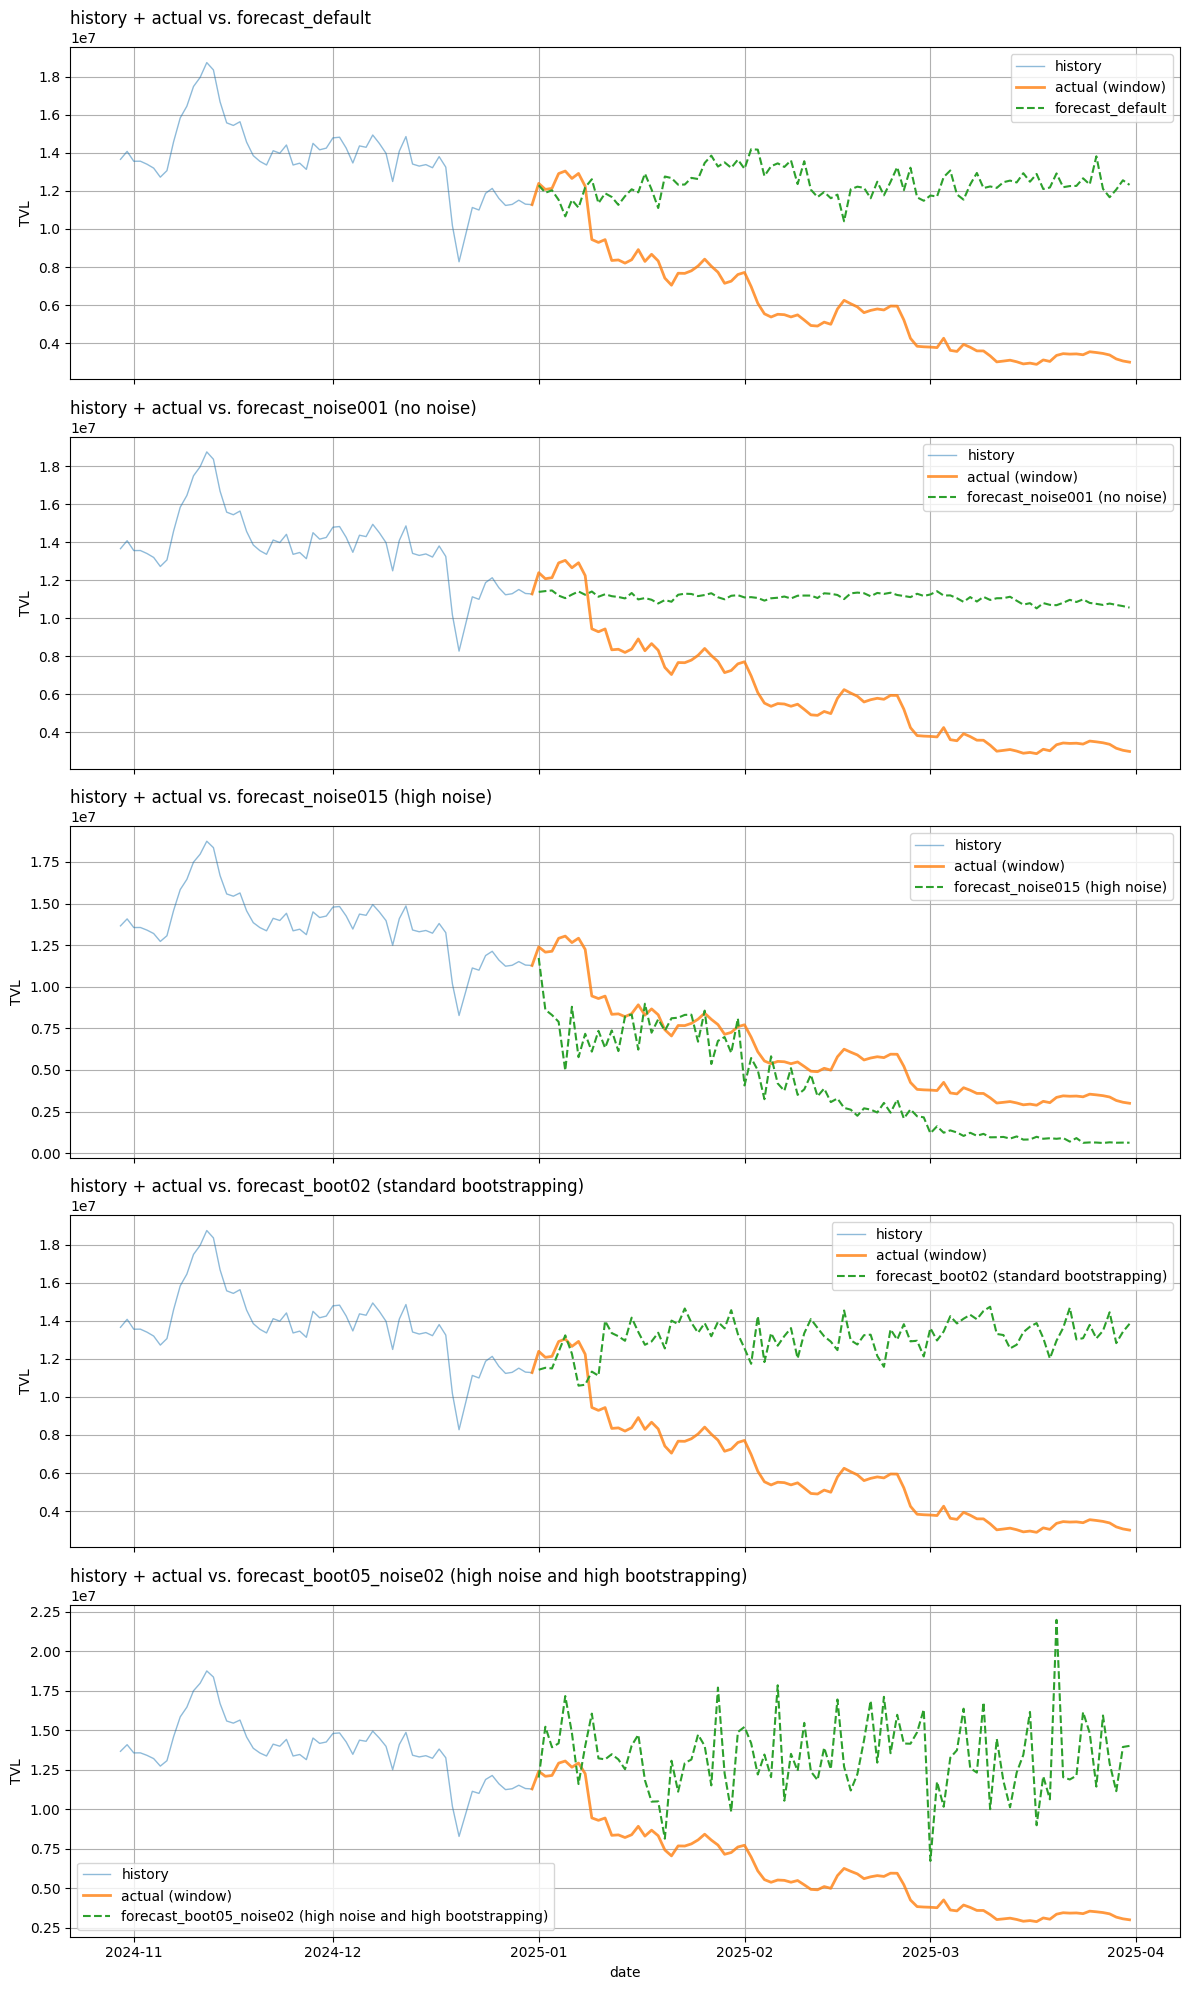

In [9]:
# ensure datetime columns
tvl_df["date"] = pd.to_datetime(tvl_df["date"])
actual_tvl_df["date"] = pd.to_datetime(actual_tvl_df["date"])
forecasted_tvl_sarima["date"] = pd.to_datetime(forecasted_tvl_sarima["date"])

# prepare subplots
forecast_cols = forecasted_tvl_sarima.columns.drop("date")
fig, axes = plt.subplots(
    nrows=len(forecast_cols),
    ncols=1,
    figsize=(12, 4 * len(forecast_cols)),
    sharex=True
)

for ax, col in zip(axes, forecast_cols):
    # 1) full historical series
    ax.plot(
        tvl_df["date"],
        tvl_df["TVL"],
        label="history",
        linewidth=1,
        alpha=0.5
    )
    # 2) actual TVL during forecast window
    ax.plot(
        actual_tvl_df["date"],
        actual_tvl_df["TVL"],
        label="actual (window)",
        linewidth=2,
        alpha=0.8
    )
    # 3) forecasted series
    ax.plot(
        forecasted_tvl_sarima["date"],
        forecasted_tvl_sarima[col],
        label=col,
        linestyle="--"
    )
    ax.set_title(f"history + actual vs. {col}", loc="left")
    ax.set_ylabel("TVL")
    ax.legend()
    ax.grid(True)

# common X label
axes[-1].set_xlabel("date")
plt.tight_layout()
plt.show()

Looking at the results, it’s clear that Renzo’s actual TVL dropped sharply, (likely due to broader market conditions). Since the SARIMA model relies solely on the protocol’s past values, it’s blind to external market shifts. That’s why its forecast significantly overshoots the real-world data—it simply couldn’t anticipate the downturn.

So, can we do better? Let’s try a different approach: a Linear Regression model that learns the relationship between the market and the protocol’s TVL. By training on historical data from both, we can forecast protocol behavior based on market trends. Keep in mind, though, this method requires access to market data and is best suited for causal inference—like analyzing the impact of a grant—not for predicting future values in isolation.

### 6. Add market context with Linear Regression 

### Choosing a market proxy  

We’ll use **`optimism-bridge` on mainnet** (a broad measure of Optimism-related liquidity) as our "market representation" and fetch the same 2024-09-01 → 2025-03-31 window.

Just like before, let's first plot it and take a look at the trends as well.

In [10]:
start_date = '2024-09-01'
end_date = '2025-03-31'

op_mainnet_tvl_df = client.to_pandas(f"""
        SELECT 
            bucket_day AS date,
            from_artifact_name AS unit,
            amount AS TVL
            FROM int_events_daily__defillama_tvl 
            WHERE to_artifact_name = 'optimism-bridge'
                AND from_artifact_namespace = 'mainnet'
                AND bucket_day BETWEEN DATE '{start_date}' AND DATE '{end_date}'
            ORDER BY 1
    """)

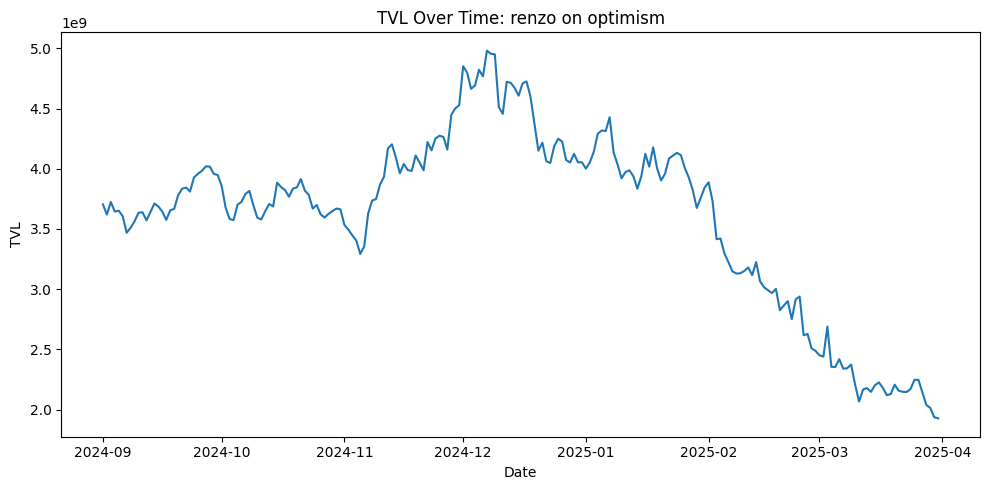

In [16]:
# ensure 'date' is a datetime type
op_mainnet_tvl_df['date'] = pd.to_datetime(op_mainnet_tvl_df['date'])

# sort by date
op_mainnet_tvl_df = op_mainnet_tvl_df.sort_values('date')

# plot
plt.figure(figsize=(10, 5))
plt.plot(op_mainnet_tvl_df['date'], op_mainnet_tvl_df['TVL'])
plt.title(f"TVL Over Time: {protocol} on {chain}")
plt.xlabel("Date")
plt.ylabel("TVL")
plt.tight_layout()
plt.show()

Below is the Linear Regression model. I chose to use a recursive implementation, where we only forecasts chunks at a time and then retrain the model on the forecasted data from the previous chunks. 

### Why use a recursive linear model?

* Recursive retraining simulates a “live” model that updates as new data comes in.
* A smaller `chunk_size` means more frequent refits—allowing quicker adaptation, but also increasing the risk of model drift.
* Setting `chunk_size` equal to `forecast_days` simplifies to a single fit—essentially just classic linear regression.

In our case, we opted for a recursive linear model that forecasts in small chunks. After each chunk, the model retrains using its previous forecasts before moving forward. This approach helps the model stay responsive to new trends, but it can be computationally expensive—especially on larger datasets. We're using it here because our data is relatively lightweight. For larger datasets, a standard linear regression model is usually more practical and efficient.

In [40]:
from sklearn.linear_model import LinearRegression


def _pct_change_safe(s: pd.Series) -> pd.Series:
    pct = s.pct_change()
    pct.replace([np.inf, -np.inf], np.nan, inplace=True)
    return pct.fillna(0)


def forecast_target_tvl_recursive(
    chain_df: pd.DataFrame,
    target_df: pd.DataFrame,
    target_col: str,
    forecast_days: int,
    *,
    chunk_size: int = 3,
    noise_std: float = 0.02,
    random_state: int | None = None,
) -> pd.DataFrame | None:
    """
    Recursive %-change forecast of `target_col`, with re-fit every `chunk_size`
    points and additive Gaussian noise `noise_std`.
    """
    rng = np.random.RandomState(random_state)

    # ── 1  align & merge history ────────────────────────────────────────────
    cdf, tdf = chain_df.copy(), target_df.copy()
    for df in (cdf, tdf):
        df["date"] = pd.to_datetime(df["date"], errors="coerce")

    c_col, t_col = f"{target_col}_chain", f"{target_col}_target"
    cdf.rename(columns={target_col: c_col}, inplace=True)
    tdf.rename(columns={target_col: t_col}, inplace=True)

    hist = (
        pd.merge(cdf[["date", c_col]], tdf[["date", t_col]], on="date", how="inner")
        .dropna()
        .sort_values("date")
        .reset_index(drop=True)
    )
    if len(hist) < 2:
        return None

    # safe %-change features
    hist["chain_ret"] = _pct_change_safe(hist[c_col])
    hist["target_ret"] = _pct_change_safe(hist[t_col])
    hist["target_lag1"] = hist["target_ret"].shift(1).fillna(0)

    model = LinearRegression(fit_intercept=False)
    model.fit(hist[["chain_ret", "target_lag1"]], hist["target_ret"])

    # ── 2  future chain returns  ────────────────────────────────────────────
    last_date = hist["date"].iloc[-1]
    future = (
        cdf[cdf["date"] > last_date]
        .sort_values("date")
        .head(forecast_days)
        .copy()
    )
    if future.empty:
        return None

    chain_full = pd.concat([hist[["date", c_col]], future[["date", c_col]]])
    chain_full = chain_full.sort_values("date").reset_index(drop=True)
    chain_full["chain_ret"] = _pct_change_safe(chain_full[c_col])
    future = future.merge(chain_full[["date", "chain_ret"]], on="date", how="left")

    # ── 3  recursive, chunk-wise loop  ───────────────────────────────────────
    preds_ret, prev_target_ret = [], hist["target_ret"].iloc[-1]
    n_left, idx = len(future), 0

    while n_left:
        sz = min(chunk_size, n_left)
        chunk = future.iloc[idx : idx + sz].copy()

        chunk_preds = []
        for _, row in chunk.iterrows():
            X = np.array([[row["chain_ret"], prev_target_ret]])
            ret = float(model.predict(X))
            ret += rng.normal(0.0, noise_std)          # additive noise
            chunk_preds.append(ret)
            preds_ret.append(ret)
            prev_target_ret = ret                      # AR(1) feedback

        # append returns and refit
        new_hist = pd.DataFrame(
            {
                "date": chunk["date"].values,
                "chain_ret": chunk["chain_ret"].values,
                "target_ret": chunk_preds,
            }
        )
        hist = pd.concat([hist, new_hist], ignore_index=True)
        hist["target_lag1"] = hist["target_ret"].shift(1).fillna(0)
        model.fit(hist[["chain_ret", "target_lag1"]], hist["target_ret"])

        idx += sz
        n_left -= sz

    # ── 4  convert returns ➜ levels  ────────────────────────────────────────
    base_level = hist[t_col].dropna().iloc[-1]     # last observed real level
    levels, prev_level = [], base_level
    for ret in preds_ret:
        prev_level *= (1 + ret)
        levels.append(prev_level)

    future[f"forecasted_{target_col}"] = levels
    return future[["date", f"forecasted_{target_col}"]]

### 7. Forecast with Linear Regression  

Just like before, I'll be training and comparing the forecasting of 4 different parameter configurations:

| Variant | Chunk size | Noise | Comment |
|---------|------------|-------|---------|
| `forecast_chunksize2` | 2 | 0.05 | Highly reactive |
| `forecast_chunksize10` | 10 | 0.05 | Smoother |
| `forecast_full` | 90 | 0.05 | One-shot fit |
| `forecast_noise015` | 3 | **0.15** | Tests robustness |

Again we overlay each forecast against reality to judge performance.

In [44]:
# suppress any warnings
warnings.filterwarnings("ignore")

# collect each variant
dfs = []

# 1) chunk_size = 2 (default noise_std=0.05)
df_cs2 = forecast_target_tvl_recursive(
    chain_df=op_mainnet_tvl_df,
    target_df=tvl_df,
    target_col='TVL',
    forecast_days=90,
    chunk_size=2
).rename(columns={'forecasted_TVL': 'forecast_chunksize2 (smaller chunk size)'})
dfs.append(df_cs2)

# 2) chunk_size = 10 (default noise_std=0.05)
df_cs10 = forecast_target_tvl_recursive(
    chain_df=op_mainnet_tvl_df,
    target_df=tvl_df,
    target_col='TVL',
    forecast_days=90,
    chunk_size=10
).rename(columns={'forecasted_TVL': 'forecast_chunksize10 (larger chunk size)'})
dfs.append(df_cs10)

# 3) full-length one-shot (non-recursive): chunk_size = forecast_days
df_full = forecast_target_tvl_recursive(
    chain_df=op_mainnet_tvl_df,
    target_df=tvl_df,
    target_col='TVL',
    forecast_days=90,
    chunk_size=90
).rename(columns={'forecasted_TVL': 'forecast_full (non-recursive)'})
dfs.append(df_full)

# 4) higher noise (noise_std=0.15, default chunk_size=3)
df_noise15 = forecast_target_tvl_recursive(
    chain_df=op_mainnet_tvl_df,
    target_df=tvl_df,
    target_col='TVL',
    forecast_days=90,
    noise_std=0.15
).rename(columns={'forecasted_TVL': 'forecast_noise015 (high noise)'})
dfs.append(df_noise15)

# merge all four forecasts on 'date'
forecasted_tvl_recursive_all = reduce(
    lambda left, right: pd.merge(left, right, on='date'),
    dfs
)

In [45]:
forecasted_tvl_recursive_all

,date,forecast_chunksize2 (smaller chunk size),forecast_chunksize10 (larger chunk size),forecast_full (non-recursive),forecast_noise015 (high noise)
0,2025-01-01,1.109122e+07,1.109484e+07,1.131957e+07,1.157930e+07
1,2025-01-02,1.155883e+07,1.087216e+07,1.119415e+07,1.025236e+07
2,2025-01-03,1.198087e+07,1.087236e+07,1.156766e+07,1.228754e+07
3,2025-01-04,1.222823e+07,1.164651e+07,1.209977e+07,9.006679e+06
4,2025-01-05,1.243545e+07,1.195223e+07,1.240978e+07,8.410510e+06
...,...,...,...,...,...
84,2025-03-26,6.734819e+06,4.502084e+06,4.288715e+06,7.465859e+06
85,2025-03-28,5.978339e+06,3.991767e+06,3.790160e+06,6.080899e+06
86,2025-03-29,6.025283e+06,3.879480e+06,3.848704e+06,8.157531e+06
87,2025-03-30,5.608487e+06,3.690787e+06,3.585178e+06,5.664343e+06


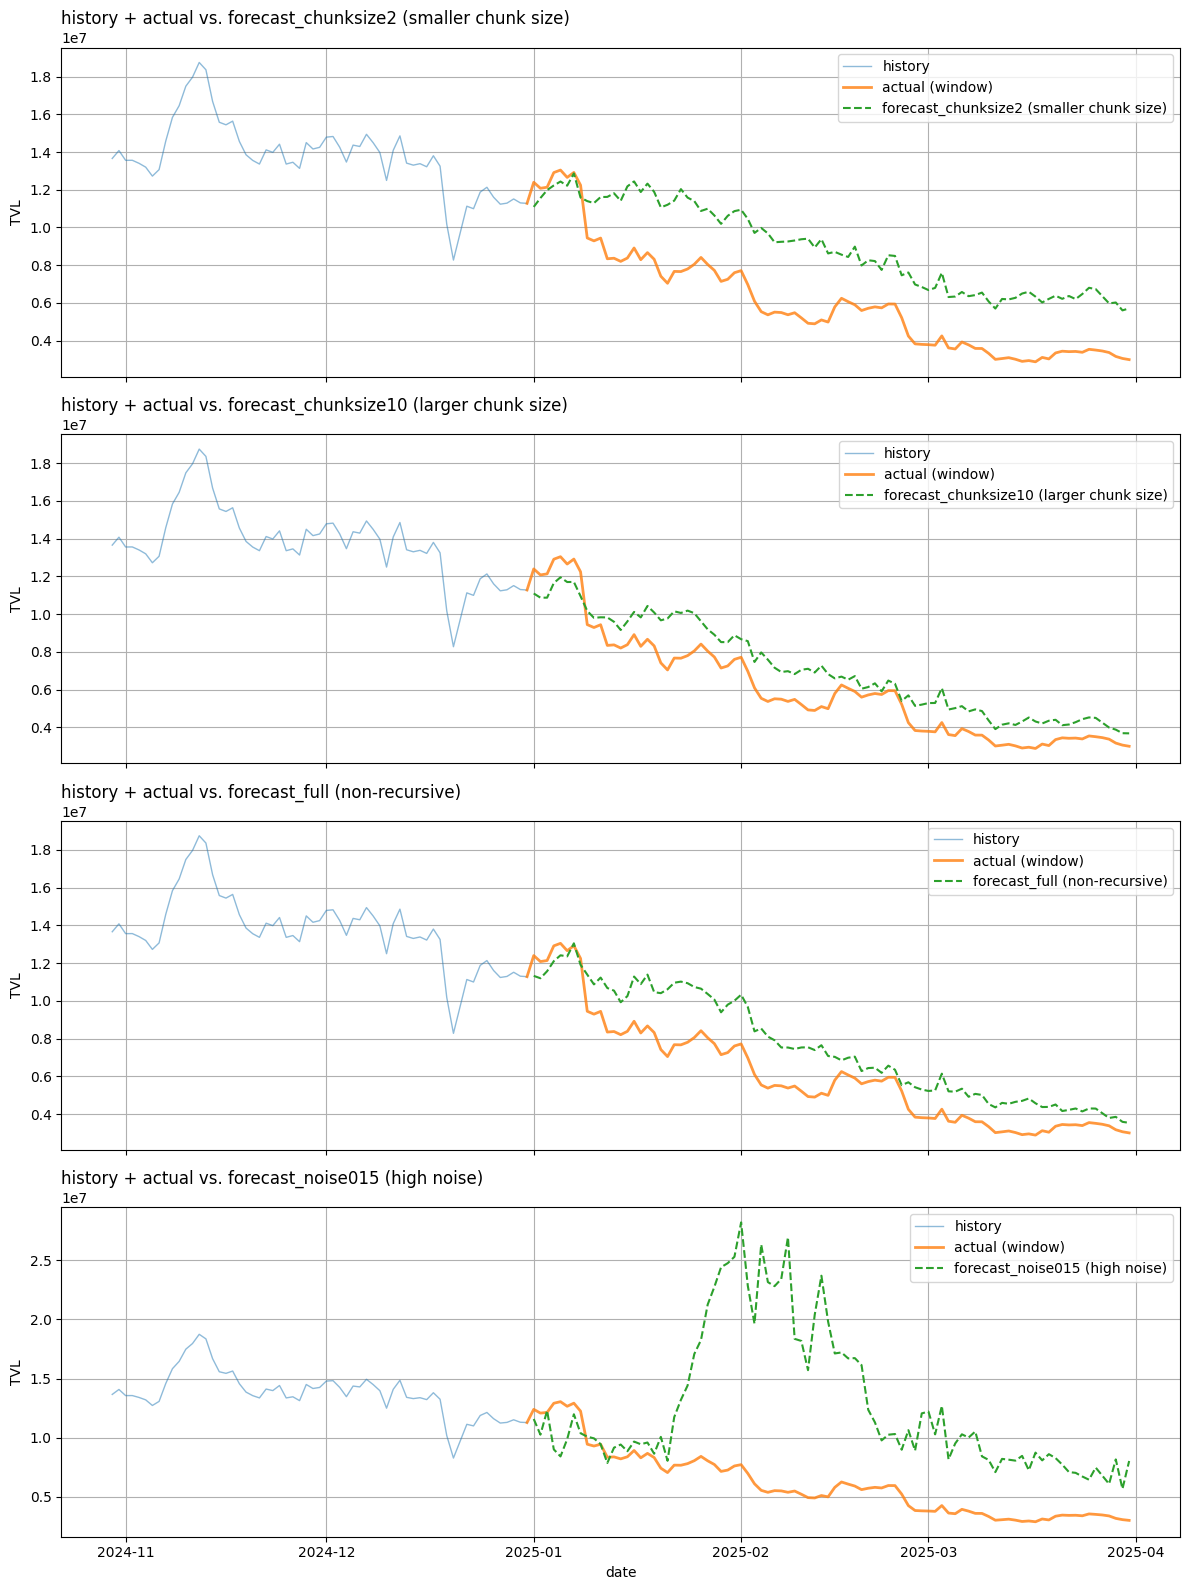

In [46]:
# ensure datetime columns
tvl_df["date"] = pd.to_datetime(tvl_df["date"])
actual_tvl_df["date"] = pd.to_datetime(actual_tvl_df["date"])
forecasted_tvl_recursive_all["date"] = pd.to_datetime(forecasted_tvl_recursive_all["date"])

# prepare subplots
forecast_cols = forecasted_tvl_recursive_all.columns.drop("date")
fig, axes = plt.subplots(
    nrows=len(forecast_cols),
    ncols=1,
    figsize=(12, 4 * len(forecast_cols)),
    sharex=True
)

for ax, col in zip(axes, forecast_cols):
    # 1) full historical series
    ax.plot(
        tvl_df["date"],
        tvl_df["TVL"],
        label="history",
        linewidth=1,
        alpha=0.5
    )
    # 2) actual TVL during forecast window
    ax.plot(
        actual_tvl_df["date"],
        actual_tvl_df["TVL"],
        label="actual (window)",
        linewidth=2,
        alpha=0.8
    )
    # 3) forecasted series
    ax.plot(
        forecasted_tvl_recursive_all["date"],
        forecasted_tvl_recursive_all[col],
        label=col,
        linestyle="--"
    )
    ax.set_title(f"history + actual vs. {col}", loc="left")
    ax.set_ylabel("TVL")
    ax.legend()
    ax.grid(True)

# common X label
axes[-1].set_xlabel("date")
plt.tight_layout()
plt.show()

### 8. Key Observations

* **Noise amplification** – Recursive models rely on their own predictions to forecast future values. That means even small amounts of noise can compound over time, pushing the forecast off-course quickly.
* **Chunk size trade-off** – Smaller chunks allow the model to respond more quickly to recent changes but can overfit short-term fluctuations. Larger chunks smooth things out, but may lag behind sudden shifts.
* **Protocol vs. market performance** – Renzo’s actual TVL consistently trails behind the forecast based on market trends, suggesting there may be protocol-specific issues at play.

From the results, it’s clear that recursive forecasting introduces a feedback loop: even modest amounts of noise can snowball and lead the model astray. While chunk size didn’t drastically change results here, the pattern still holds—smaller chunks make the model more reactive (and volatile), while larger chunks lead to steadier, more conservative predictions.

In the case of Renzo, its underperformance relative to the broader Optimism trend points to internal factors beyond general market conditions—an insight that could be valuable for diagnosing protocol health.

---

### Wrapping up

And that’s a wrap! Using PyOSO, I was able to run a fairly detailed forecasting analysis on a live protocol in under an hour—from exploring raw data to comparing different models side-by-side.

We tried out multiple modeling strategies, including SARIMA for time-series-only forecasting and a recursive Linear Regression approach to incorporate broader market trends. Along the way, we experimented with hyperparameters like `chunk_size` and `noise_std` to understand how model assumptions shape predictions. Even with light tuning, the framework gave us useful insights into both general market coupling and protocol-specific deviations.

I'd love to hear what you think—try it out on another protocol, explore different modeling setups, test performance across chains, or plug in alternative market proxies. If you uncover something interesting, have feedback, or want to collaborate, feel free to reach out!

– Evan Meyer (evan.meyer@karibalabs.co)